# Predicting Hospital Readmission

### Introduction


### Attributes
- **Encounter_id**: Unique identifier of an encounter.
- **Patient_nbr**: Unique identifier of a patient.
- **Race**: Caucasian, Asian, African American, Hispanic, and other.
- **Gender**: male, female, and unknown/invalid.
- **Age**: Grouped in 10-year intervals: 0, 10), 10, 20), …, 90, 100).
- **Weight**: Weight in pounds.
- **Admission type**: Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available.
- **Discharge disposition**: Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available.
- **Admission source**: Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital.
- **Time in hospital**: Integer number of days between admission and discharge.
- **Payer code**: Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay.
- **Medical specialty**: Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon.
- **Number of lab procedures**: Number of lab tests performed during the encounter.
- **Number of procedures**: Number of procedures (other than lab tests) performed during the encounter.
- **Number of medications**: Number of distinct generic names administered during the encounter.
- **Number of outpatient visits**: Number of outpatient visits of the patient in the year preceding the encounter.
- **Number of emergency visits**: Number of emergency visits of the patient in the year preceding the encounter.
- **Number of inpatient visits**: Number of inpatient visits of the patient in the year preceding the encounter.
- **Diagnosis 1**: The primary diagnosis (coded as first three digits of ICD9); 848 distinct values.
- **Diagnosis 2**: Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values.
- **Diagnosis 3**: Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values.
- **Number of diagnoses**: Number of diagnoses entered to the system 0%
- **Glucose serum test result**: Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured.
- **A1c test result**: Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.
- **Change of medications**: Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”.
- **Diabetes medications**: Indicates if there was any diabetic medication prescribed. Values: `yes` and `no`.
- **24 features for medications**: Medications under their generic names: metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride- pioglitazone, metformin-rosiglitazone, and metformin- pioglitazone, the feature indicates whether the drug was prescribed or there was a change in the dosage. _Values: `up` if the dosage was increased during the encounter, `down` if the dosage was decreased, `steady` if the dosage did not change, and `no` if the drug was not prescribed._
- **Readmitted**: Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission


#### Problem

## Imports & Read Data

In [27]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [28]:
# read data
PATH_df = r'C:\Users\alindsey\Documents\hospital_readmissions\Data\Raw\diabetic_data.csv'
PATH_codes = r'C:\Users\alindsey\Documents\hospital_readmissions\Data\Raw\IDs_mapping.csv'
df = pd.read_csv(PATH_df)
codes = pd.read_csv(PATH_codes)

In [29]:
# # read data MAC
# df = pd.read_csv('Data/Raw/diabetic_data.csv')
# codes = pd.read_csv('Data/Raw/IDs_mapping.csv')

## Clean Data

### codes

In [30]:
# clean codes
codes = codes[(codes['description']!='description')] 

# merge
codes = pd.merge(codes.copy()[40:].rename(columns={'description':'admission_source_id',
                                                     'admission_type_id':'values'}),
                 (pd.merge(codes.copy()[0:8].rename(columns={'description':'admission_type_id',
                                                             'admission_type_id':'values'}),
                           codes.copy()[9:39].rename(columns={'description':'discharge_disposition_id',
                                                              'admission_type_id':'values'}),
                           how='outer',
                           left_on='values',
                           right_on='values')),
                 how='outer',
                 left_on='values',
                 right_on='values').reset_index(drop=True)

# some NAN should actually be NULL
codes.loc[15, 'admission_source_id'] = 'NULL'
codes.loc[5, 'admission_type_id'] = 'NULL'
codes.loc[16, 'discharge_disposition_id'] = 'NULL'
codes.head(10)

,values,admission_source_id,admission_type_id,discharge_disposition_id
0,1,Physician Referral,Emergency,Discharged to home
1,2,Clinic Referral,Urgent,Discharged/transferred to another short term h...
2,3,HMO Referral,Elective,Discharged/transferred to SNF
3,4,Transfer from a hospital,Newborn,Discharged/transferred to ICF
4,5,Transfer from a Skilled Nursing Facility (SNF),Not Available,Discharged/transferred to another type of inpa...
5,6,Transfer from another health care facility,NULL,Discharged/transferred to home with home healt...
6,7,Emergency Room,Trauma Center,Left AMA
7,8,Court/Law Enforcement,Not Mapped,Discharged/transferred to home under care of H...
8,9,Not Available,NaN,Admitted as an inpatient to this hospital
9,10,Transfer from critial access hospital,NaN,Neonate discharged to another hospital for neo...


### Primary df

In [31]:
# clean df
df.replace('?', np.nan, inplace=True)

# drop encounter_id
df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

# make outcome variable binary
df['readmitted'].replace({'<30':'YES', '>30':'YES'}, inplace=True)
df.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,YES
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [32]:
# # no drug df
# no_drug_df = pd.merge(df[list(df.columns[0:24])], 
#                       df[list(df.columns[-3:])],
#                       how='inner',
#                       left_index=True,
#                       right_index=True)

# no_drug_df.head()

In [33]:
# # drug df
# drugs_df = df[list(df.columns[24:-3])]
# drugs_df.head()

## Initial Investigation

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   weight                    3197 non-null    object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   payer_code                61510 non-null   object
 9   medical_specialty         51817 non-null   object
 10  num_lab_procedures        101766 non-null  int64 
 11  num_procedures            101766 non-null  int64 
 12  num_medications           101766 non-null  int64 
 13  number_outpatient         101766 non-null  int64 
 14  numb

In [35]:
pd.options.display.float_format = "{:.2f}".format # two decimal places
# df.drop(columns={'patient_nbr'}).describe()
df.describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00
mean,2.02,3.72,5.75,4.40,43.10,1.34,16.02,0.37,0.20,0.64,7.42
std,1.45,5.28,4.06,2.99,19.67,1.71,8.13,1.27,0.93,1.26,1.93
min,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00
25%,1.00,1.00,1.00,2.00,31.00,0.00,10.00,0.00,0.00,0.00,6.00
50%,1.00,1.00,7.00,4.00,44.00,1.00,15.00,0.00,0.00,0.00,8.00
75%,3.00,4.00,7.00,6.00,57.00,2.00,20.00,0.00,0.00,1.00,9.00
max,8.00,28.00,25.00,14.00,132.00,6.00,81.00,42.00,76.00,21.00,16.00


### Missing Values

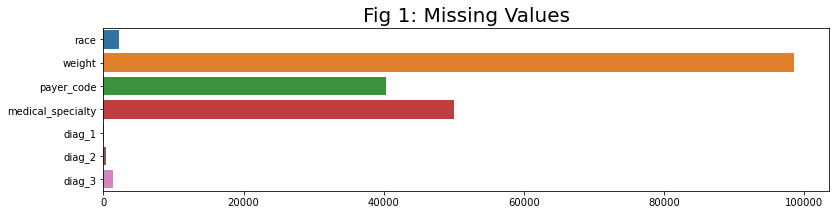

In [36]:
fig, ax = plt.subplots(figsize=(13, 3))

sns.barplot(x=df.isnull().sum()[df.isnull().sum()>0],
            y=df.columns[df.isna().any()].tolist(),
            orient='h')

plt.title('Fig 1: Missing Values', size=20);

#### Weight, Payer Code, Medical Specialty

Over 90% of `weight` is missing, so it is dropped from the dataset. `payer_code`, `medical_specialty` are both dropped as nearly 50% are missing. 

The other variables are missing a small percentage of their observations.

In [37]:
df.drop(['weight', 'payer_code', 'medical_specialty', 'diag_2', 'diag_3'], axis=1, inplace=True)

## Exploratory Analysis

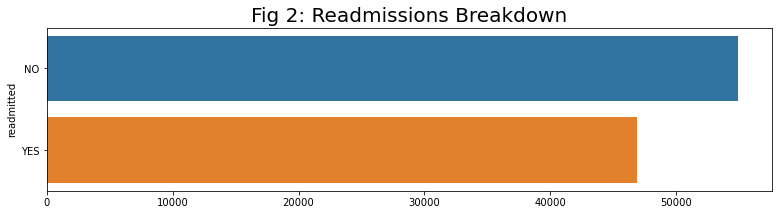

In [38]:
fig, ax = plt.subplots(figsize=(13, 3))

sns.countplot(y='readmitted', data=df)
plt.title('Fig 2: Readmissions Breakdown', size=20)
plt.xlabel('');

### Non-Drug Features vs. Readmission (Non-Drugs)

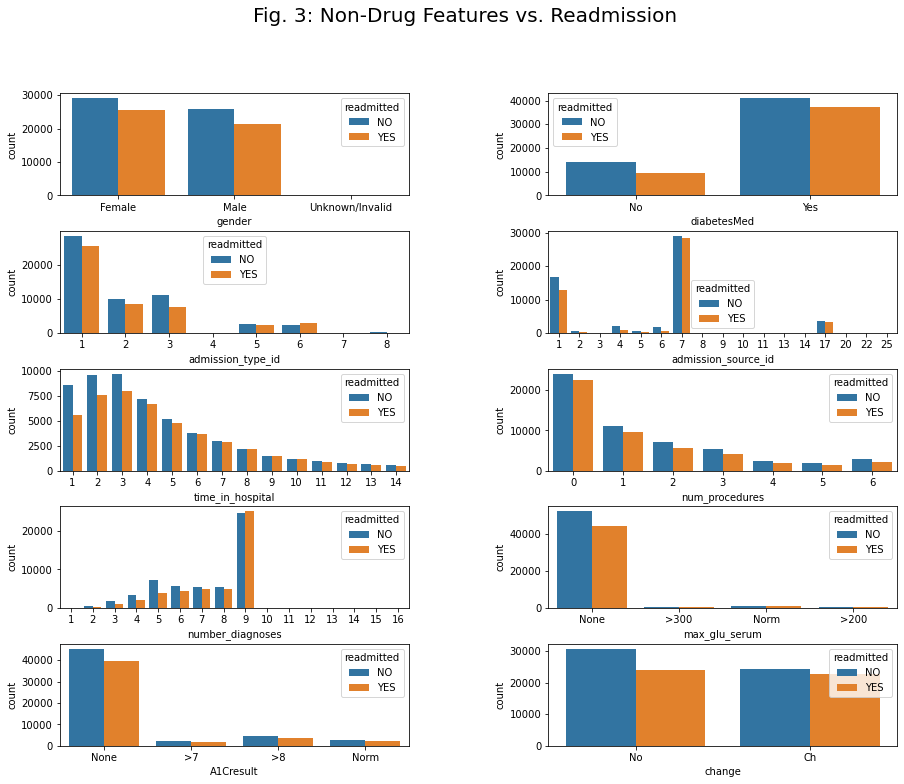

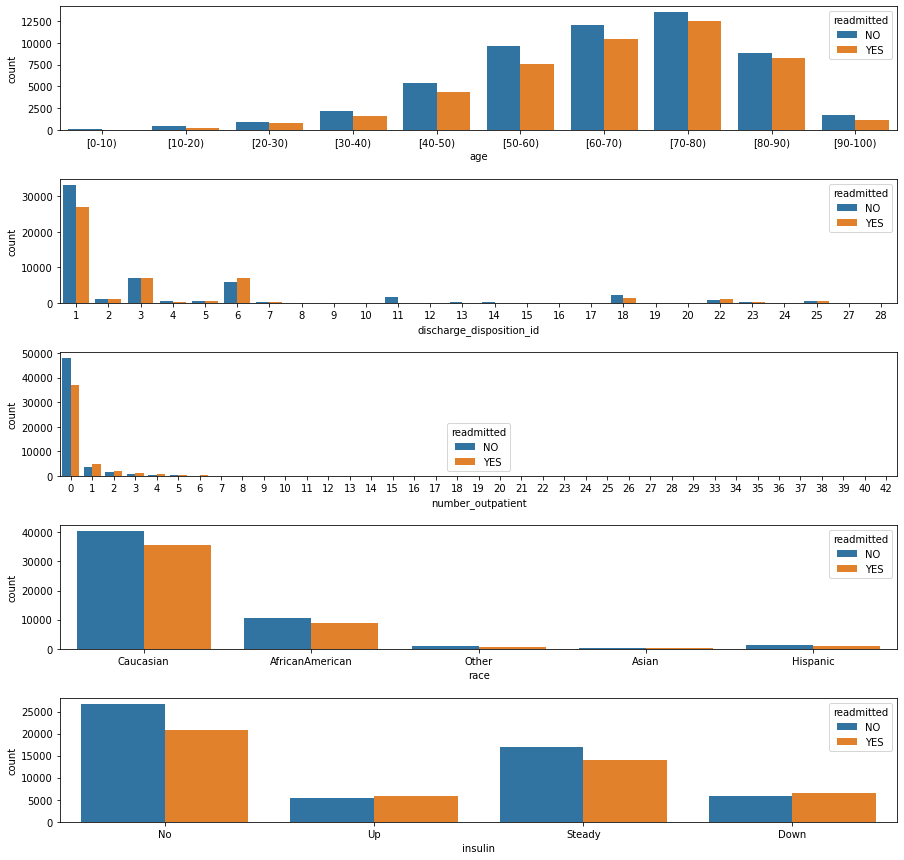

In [39]:
hue = df['readmitted']

# top 5 rows
fig, ((ax1, ax2),
      (ax3, ax4),
      (ax5, ax6),
      (ax7, ax8),
      (ax9, ax10)) = plt.subplots(5, 2, figsize=(15,12))


fig.subplots_adjust(hspace=0.35, wspace=.4)
fig.suptitle('Fig. 3: Non-Drug Features vs. Readmission', size=20)

sns.countplot(x=df['gender'], hue=hue, ax=ax1)
sns.countplot(x=df['diabetesMed'], hue=hue, ax=ax2)
sns.countplot(x=df['admission_type_id'], hue=hue, ax=ax3)
sns.countplot(x=df['admission_source_id'], hue=hue, ax=ax4)
sns.countplot(x=df['time_in_hospital'], hue=hue, ax=ax5)
# sns.countplot(x=df['num_lab_procedures'], hue=hue, ax=ax10)
# sns.countplot(x=df['medical_specialty'], hue=hue, ax=ax11)
sns.countplot(x=df['num_procedures'], hue=hue, ax=ax6)
# sns.countplot(x=df['num_medications'], hue=hue, ax=ax11)
sns.countplot(x=df['number_diagnoses'], hue=hue, ax=ax7)
sns.countplot(x=df['max_glu_serum'], hue=hue, ax=ax8)
sns.countplot(x=df['A1Cresult'], hue=hue, ax=ax9)
sns.countplot(x=df['change'], hue=hue, ax=ax10)



# bottom 7 rows
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

sns.countplot(x=df['age'], hue=hue, ax=ax1)
sns.countplot(x=df['discharge_disposition_id'], hue=hue, ax=ax2)
sns.countplot(x=df['number_outpatient'], hue=hue, ax=ax3)
sns.countplot(x=df['race'], hue=hue, ax=ax4)
sns.countplot(x=df['insulin'], hue=hue, ax=ax5);

In [40]:
# def corr_plot(df, title='Correlation Plot', figsize=(25, 10), max_cols=20):
#     """
#     Prints correlation plot. If number of columns > max_cols then annotations are turned off. 
#     """
#   
#     plt.style.use('seaborn-whitegrid')
#     fig = plt.figure(figsize=figsize)
#     mask = np.zeros_like(df.corr(), dtype=np.bool)
#     mask[np.triu_indices_from(mask)] = True
    
#     # if too many columns, plot gets messy because of in-box annotations
#     if len(df.columns)>max_cols:
#         annot = False
#     else:
#         annot = True   
    
#     sns.heatmap(df.corr(),
#                 annot=annot,
#                 vmin=-1, vmax=1,
#                 square=True, 
#                 cmap=sns.color_palette('RdBu_r', 100),
#                 mask=mask,
#                 linewidths=0.5)
#     # title
#     plt.title(title, size=20)

# corr_plot(df)

# Impute Missing Values

In [41]:
df.rename(columns={'diag_1':'diagnosis'}, inplace=True)

In [42]:
for i in df.index:
    current_race = df.at[i, 'race']
    current_diag_1 = df.at[i, 'diagnosis']
    
    if pd.isnull(current_race)==True:
        df.at[i, 'race'] = 'Caucasian'
    
    if pd.isnull(current_diag_1)==True:
        df.at[i, 'diagnosis'] = 428

# Feature Engineering

## How many times seen before

## Number outpatient

For 

## Categorization of Diagnoses

There are hundreds of different diagnoses here. The broad categories are available [here](https://en.wikipedia.org/wiki/List_of_ICD-9_codes). 

In [43]:
from tqdm import tqdm

for i in tqdm(df.index):
    d = df.at[i, 'diagnosis']
    
    try:
        df.at[i, 'diagnosis'] = float(df.at[i, 'diagnosis'])
        
    except ValueError:
        if 'E' in d:
            df.at[i, 'diagnosis'] = 'external cause of injury'

        else:
            df.at[i, 'diagnosis'] = 'other'
    else:
        d = float(df.at[i, 'diagnosis'])
        
        if d>=1 and d<=139:
            df.at[i, 'diagnosis'] = 'infections/parasitic'
        elif d>=140 and d<=239:
            df.at[i, 'diagnosis'] = 'neoplasms'
        elif d>=240 and d<=279:
            df.at[i, 'diagnosis'] = 'endocrine/nutrition/immunity'
        elif d>= 280 and d<=289:
            df.at[i, 'diagnosis'] = 'blood'
        elif d>=290 and d<=319:
            df.at[i, 'diagnosis'] = 'mental disorders'
        elif d>=320 and d<=329:
            df.at[i, 'diagnosis'] = 'nervous system'
        elif d>=390 and d<=459:
            df.at[i, 'diagnosis'] = 'circulatory'
        elif d>=460 and d<=519:
            df.at[i, 'diagnosis'] = 'respiratory'
        elif d>=520 and d<=579:
            df.at[i, 'diagnosis'] = 'digestive'
        elif d>=580 and d<=629:
            df.at[i, 'diagnosis'] = 'genitourinary'
        elif d>=630 and d<=679:
            df.at[i, 'diagnosis'] = 'pregnancy/childbirth'
        elif d>=680 and d<=709:
            df.at[i, 'diagnosis'] = 'skin/subcutaneous tissue'
        elif d>=710 and d<=739:
            df.at[i, 'diagnosis'] = 'musculoskeletal'
        elif d>=740 and d<=759:
            df.at[i, 'diagnosis'] = 'congenital anomalies'
        elif d>=760 and d<=779:
            df.at[i, 'diagnosis'] = 'perinatal'
        elif d>=780 and d<=799:
            df.at[i, 'diagnosis'] = 'ill-defined'
        else:
            df.at[i, 'diagnosis'] = 'injury/poisoning'

100%|██████████| 101766/101766 [00:02<00:00, 42118.24it/s]


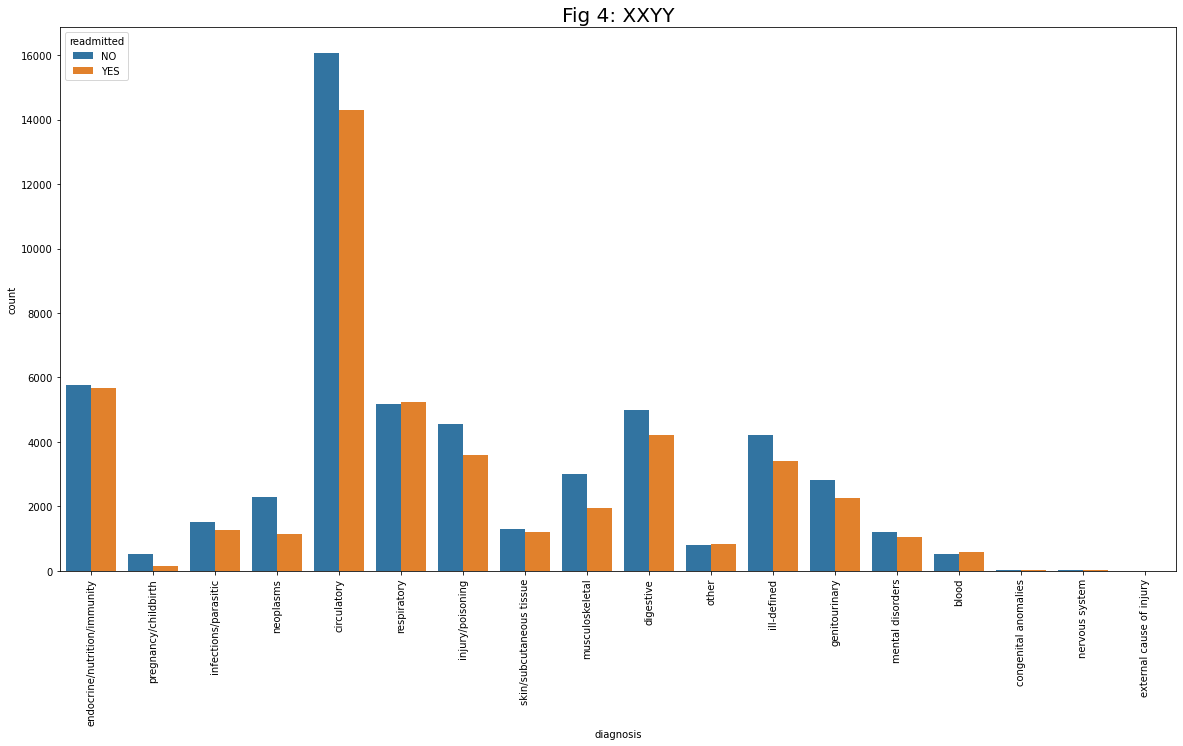

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.countplot(x=df['diagnosis'], hue=hue, ax=ax)
_ = plt.xticks(rotation=90)
plt.title('Fig 4: XXYY', size=20);

# Encode Variables

In [45]:
continuous_cols = []

for c in df.columns:
    if df[c].dtype=='int64':
        if 'id' not in c:
            continuous_cols.append(c)
            
categorical_cols = [col for col in df.columns if col not in continuous_cols]
df_ohe = pd.get_dummies(data=df, columns=categorical_cols, drop_first=True)

# Splitting - Train & Test

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df_ohe.drop(['readmitted_YES'], axis=1), 
                                                    df_ohe['readmitted_YES'],
                                                    train_size=.75,
                                                    shuffle=True,
                                                    random_state=1)

# Scaling

In [47]:
ct = ColumnTransformer(transformers=[('scaler', StandardScaler(), continuous_cols)],
                       remainder='passthrough')

In [48]:
X_train = pd.DataFrame(ct.fit_transform(X_train),
                       columns=X_train.columns)
X_train.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Asian,race_Caucasian,...,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes
0,2.22,0.40,-0.20,-0.50,-0.29,-0.21,0.29,0.30,0.00,1.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
1,-0.47,-1.43,-0.78,-0.86,1.27,-0.21,1.08,-1.25,0.00,1.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,-0.47,0.60,-0.78,-0.50,-0.29,-0.21,-0.50,0.82,0.00,1.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,-1.14,-1.03,0.39,-1.85,-0.29,-0.21,-0.50,-1.25,0.00,1.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,-0.13,-0.06,-0.78,-0.62,2.05,-0.21,-0.50,-1.25,0.00,1.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


# Analysis

In [49]:
scores = {} # create empty dict to store models and cross validation best scores

def results(estimator):
    """
    1. Adds fitted model and best score from RandomizedSearchCV to scores dictionary.
    2. Prints fitted model best parameters and best score
    """
    scores[estimator] = estimator.best_score_ # add fitted model and .best_score_ to models dictionary
    return print(f'Best params: {estimator.best_params_}'+ f'\nBest estimator score: {estimator.best_score_}')

In [50]:
# def results(estimator):
#     """
#     1. Adds fitted model and best score from RandomizedSearchCV to scores dictionary. If scores dictionary doesn't exist, 
#        it creates an empty dictionary named scores.
#     2. Prints fitted model best parameters and best score.
#     """
    
#     try:
#         scores
#     except NameError:
#         scores={}
#         scores[estimator] = estimator.best_score_ # add fitted model and .best_score_ to models dictionary
#         return print(f'Best params: {estimator.best_params_}'+ f'\nBest estimator score: {estimator.best_score_}')
#     else:
#         scores[estimator] = estimator.best_score_ # add fitted model and .best_score_ to models dictionary
#         return print(f'Best params: {estimator.best_params_}'+ f'\nBest estimator score: {estimator.best_score_}')

In [51]:
# Logistic Regression, no regularization
params = {'C':list(range(1, 10))}
logistic = RandomizedSearchCV(LogisticRegression(penalty='none',
                                                 solver='lbfgs'), 
                              param_distributions=params, 
                              n_jobs=-1, 
                              cv=5,
                              verbose=1)
logistic.fit(X_train, y_train)
results(logistic)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   24.8s finished


Best params: {'C': 1}
Best estimator score: 0.635160589714485


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
